# EMA trading

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive_output, jslink
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText, IntText, Dropdown
from IPython.display import display, clear_output

import trading as tra
import trading_plots as trp
import trading_defaults as dft

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

### Default parameters

In [2]:
color_schemes = dft.SURFACE_COLOR_SCHEMES
START_DATE = '2017-07-15'
TODAY     = dft.TODAY

In [3]:
END_DATE = TODAY
#END_DATE = '2021-04-06'

TICKER     = 'ETH-USD'
REFRESH    = False # Download fresh Yahoo data 
print(START_DATE, 'to',END_DATE)

2017-07-15 to 2021-04-08


### Data download

In [4]:
try:
    raw, ticker_name = tra.load_security(dirname = dft.DATA_DIR, 
                                        ticker  = TICKER, 
                                        refresh = REFRESH, 
                                        period  = dft.DEFAULT_PERIOD,
                                        )
    print (raw)
except IndexError:
        print(f'Could not load {TICKER}')
except:
    print(f'Error type {sys.exc_info()[0]}')
else:
    security = pd.DataFrame(raw[f'Close_{TICKER}'])
    security.rename(columns={f'Close_{TICKER}': "Close"},
                    inplace=True)
security

Loading data from data/ETH-USD/ETH-USD_5y.pkl
            Close_ETH-USD  Vol_ETH-USD
Date                                  
2016-04-08      9.7195902     14660600
2016-04-09      9.1506205     16194800
2016-04-10      8.9363403     42613400
2016-04-11      8.6437902     15138100
2016-04-12      7.4423099     23190100
...                   ...          ...
2021-04-04   2093.1228027  26006501902
2021-04-05   2107.8872070  28889391170
2021-04-06   2118.3789062  29222865881
2021-04-07   1971.0772705  36116271935
2021-04-08   1999.3740234  34794110976

[1823 rows x 2 columns]


,Close
Date,
2016-04-08,9.7195902
2016-04-09,9.1506205
2016-04-10,8.9363403
2016-04-11,8.6437902
2016-04-12,7.4423099
...,...
2021-04-04,2093.1228027
2021-04-05,2107.8872070
2021-04-06,2118.3789062


#### Setup default start & end dates

In [5]:
# Check dates 
date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
#print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_date_range(security, START_DATE, END_DATE))
#print(tra.get_filename_dates(security, START_DATE, END_DATE))

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 4, 8, 0, 0)]


In [6]:
def save_figure(plot_dir, prefix, dpi=360, extension='png'):
    '''
    Saves figure to file
    variables:
        plot_dir - directory to plot to
        prefix   - filename without its extension
    '''
    filename = f'{prefix}.{extension}'
    pathname = os.path.join(plot_dir, filename)
    print(f'Saving to {pathname}')
    try:
        plt.savefig(pathname,
                    dpi = dpi,
                    transparent = False,
                    facecolor='white',
                    edgecolor='none',
                    orientation = 'landscape',
                    bbox_inches = 'tight'
                    )
    except TypeError as ex:
        print(f'Could not save to {pathname}: {ex}')
    except:
        print(f'Error type {sys.exc_info()[0]}')
    else:
        pass

## Plotting functions

In [28]:
#def plot_time_series(ticker, ticker_name, date_range, display_dates, security, span, fee_pct, buffer, flags):

def plot_time_series(span, display_dates, fee_pct, buffer, price_flag, ema_flag, buffer_flag, arrow_flag, stats_flag):
    save_flag = False
    flags = [price_flag, ema_flag, buffer_flag, arrow_flag, stats_flag, save_flag]

    trp.plot_time_series(ticker      = TICKER, 
                         ticker_name = ticker_name, 
                         date_range  = date_range,
                         display_dates  = display_dates, 
                         security    = security, 
                         span        = span, 
                         fee_pct     = dft.FEE_PCT, 
                         buffer      = buffer,
                         flags       = flags,
                        )

In [8]:
def plot_span_range(buffer, n_best, fee_pct, date_range):
    trp.plot_span_range(buffer      = buffer, 
                        n_best      = n_best, 
                        fee_pct     = fee_pct, 
                        date_range  = date_range, 
                        ticker      = TICKER, 
                        ticker_name = ticker_name,
                        security    = security, 
                       )

In [9]:
def plot_buffer_range(span, n_best, fee_pct, date_range):
    trp.plot_buffer_range(span        = span, 
                          n_best      = n_best, 
                          fee_pct     = fee_pct, 
                          date_range  = date_range, 
                          ticker      = TICKER, 
                          ticker_name = ticker_name,
                          security    = security, 
                         )

In [10]:
# test driver for trp.plot_span_range
%time 
plot = False
if plot:
    #%prun -D plot_span_range.prof 
    plot_span_range(buffer     = .01, 
                    n_best     = 12, 
                    fee_pct    = dft.FEE_PCT, 
                    date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                  datetime.strptime(END_DATE, '%Y-%m-%d')], 
                   )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [11]:
# test driver for trp.plot_buffer_range
%time 
plot = False
if plot:
    %time 
    #%prun -D plot_buffer_range.prof
    plot_buffer_range(span       = 20, 
                      n_best     = 12, 
                      fee_pct    = dft.FEE_PCT, 
                      date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                    datetime.strptime(END_DATE, '%Y-%m-%d')], 
                    )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [12]:
date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
print(date_range)
#tra.read_ema_map(TICKER, date_range)
#ATO.PA_2017-07-15_2021-03-25_ema_map

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 4, 8, 0, 0)]


In [13]:
def load_ema():
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    if os.path.exists(tra.get_ema_map_filename(TICKER, date_range)):
        print('Loading EMA map from file')
        spans, buffers, emas, hold  = tra.read_ema_map(TICKER, date_range,)
    else: # If not saved, compute it & save it to file
        print('Computing EMA map')
        spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range,)
        tra.save_ema_map(TICKER, date_range, spans, buffers, emas, hold)
    return spans, buffers, emas, hold

spans, buffers, emas, hold = load_ema()

Loading EMA map from file


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs

Max EMA 0=7073.03%: 29-days buffer=1.65% (hold=1071.59%)
Max EMA 1=6791.28%: 28-days buffer=1.82% (hold=1071.59%)
Max EMA 2=6791.28%: 28-days buffer=1.86% (hold=1071.59%)
Max EMA 3=6791.28%: 28-days buffer=1.89% (hold=1071.59%)
Max EMA 4=6742.07%: 29-days buffer=1.68% (hold=1071.59%)
Max EMA 5=6742.07%: 29-days buffer=1.72% (hold=1071.59%)
Max EMA 6=6742.07%: 29-days buffer=1.75% (hold=1071.59%)
Max EMA 7=6742.07%: 29-days buffer=1.79% (hold=1071.59%)
Max EMA 8=6688.74%: 28-days buffer=1.93% (hold=1071.59%)
Max EMA 9=6640.27%: 29-days buffer=1.82% (hold=1071.59%)


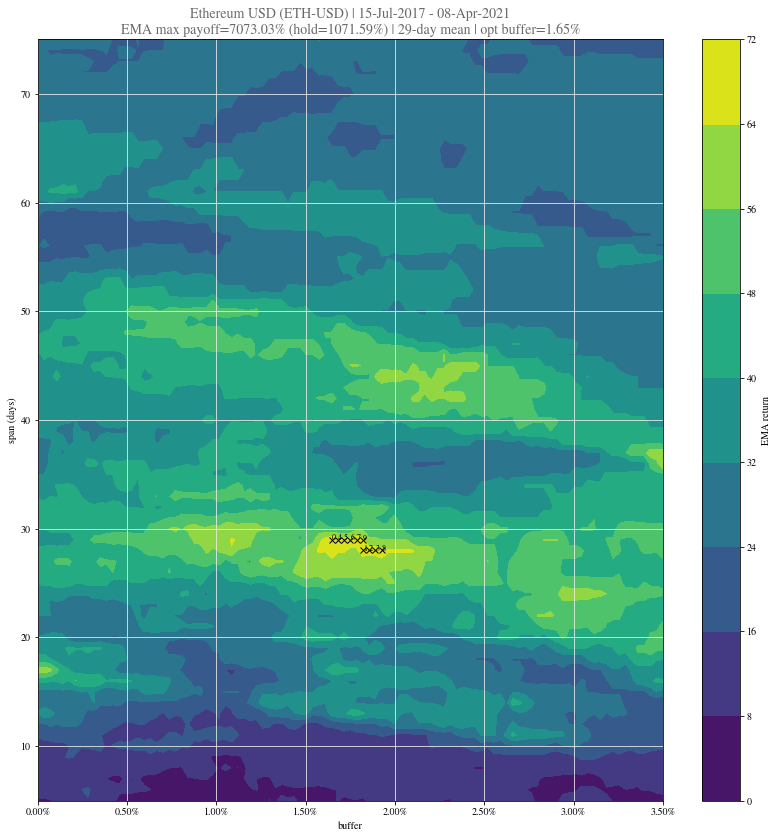

In [14]:
# Driver for plot_buffer_span_contours
plot = True
if plot:
    %time 
    #%prun -D plot_contours.prof
    trp.plot_buffer_span_contours(TICKER, ticker_name, date_range, spans, buffers, emas, hold)

In [15]:
def plot_buffer_span_3D(azimuth, elevation, rdist, colors):
    trp.plot_buffer_span_3D(ticker      = TICKER,
                            ticker_name = ticker_name, 
                            date_range  = date_range, 
                            spans       = spans, 
                            buffers     = buffers, 
                            emas        = emas, 
                            hold        = hold, 
                            elev        = elevation, 
                            azim        = -azimuth, 
                            rdist       = rdist,
                            colors      = colors,
                           )

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


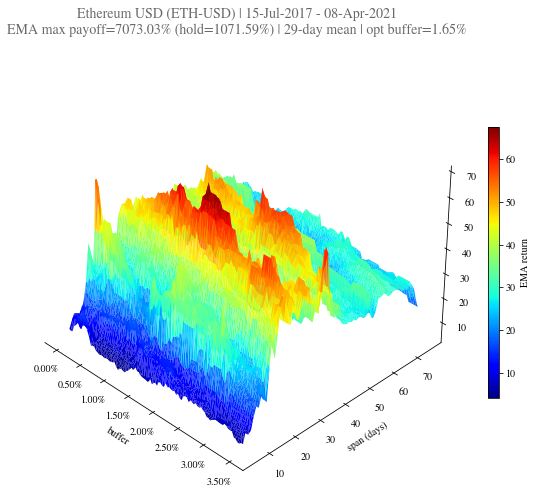

In [16]:
# Driver for plot_buffer_span_3D
plot = True
if plot:
    %time 
    #%prun -D plot_3D.prof
    trp.plot_buffer_span_3D(TICKER, ticker_name, date_range, 
                                  spans, buffers, emas, hold,
                                  colors=dft.SURFACE_COLOR_SCHEME,
                                  azim=dft.PERSPECTIVE[0], 
                                  elev=dft.PERSPECTIVE[1], 
                                  rdist=dft.PERSPECTIVE[2],
                                 )

### Interactive plots

#### Widget defaults

In [17]:
def get_default_parameters(ticker, date_range):
    try: # ema file exists
        spans, buffers, emas, hold = tra.read_ema_map(ticker, date_range)
        df = tra.get_best_emas(spans, buffers, emas, hold, 1)
        opt_span, opt_buff , opt_ema, opt_hold = df.span[0], df.buffer[0], df.ema[0], df.hold[0]
    except Exception as ex:
        print(f'Could not process {ticker}: Exception={ex}') 
        raise ValueError('aborting')
        opt_span, opt_buff , opt_ema, opt_hold = dft.DEFAULT_SPAN, dft.DEFAULT_BUFFER, 0, 0 
    return opt_span, opt_buff , opt_ema, opt_hold

date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
best_span, best_buffer, best_ema, hold = get_default_parameters(TICKER, date_range)
print(f'Optimal span={best_span:.0f}, buffer={best_buffer:.2%}, EMA strategy returns={best_ema:.2%} (hold={hold:.2%})')

Optimal span=29, buffer=1.65%, EMA strategy returns=7073.03% (hold=1071.59%)


In [18]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_date_range(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

best_span, best_buffer, _, _ = get_default_parameters(TICKER, date_range)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = dft.FEE_PCT

# of days for running mean
min_span     = dft.MIN_SPAN
max_span     = dft.MAX_SPAN
delta_span   = 1
default_span = best_span

# buffer around EMA
min_buffer     = dft.MIN_BUFF
max_buffer     = dft.MAX_BUFF
delta_buffer   = .0001
default_buffer = best_buffer

# number of maxima
max_value     = 15
default_value = 12

# 3D horizontal & vertical sliders
min_azimuth     = dft.MIN_AZIMUTH
max_azimuth     = dft.MAX_AZIMUTH
delta_azimuth   = 1
default_azimuth = dft.PERSPECTIVE[0]

min_elevation     = dft.MIN_ELEVATION
max_elevation     = dft.MAX_ELEVATION
delta_elevation   = 1
default_elevation = dft.PERSPECTIVE[1]

min_distance     = dft.MIN_DISTANCE
max_distance     = dft.MAX_DISTANCE
delta_distance   = 1
default_distance = dft.PERSPECTIVE[2]

surface_color_scheme = color_schemes[12]

In [19]:
## Widget methods
### Sliders
def get_span_slider():
    return IntSlider(min      = min_span,
                     max      = max_span,
                     step     = delta_span,
                     value    = default_span,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
    return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options  = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )

def get_azimuth_slider():
    return IntSlider(min      = min_azimuth,
                     max      = max_azimuth,
                     step     = delta_azimuth,
                     value    = default_azimuth,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_elevation_slider():
    return IntSlider(min      = min_elevation,
                     max      = max_elevation,
                     step     = delta_elevation,
                     value    = default_elevation,
                     style    = string_style,
                     disabled = False,
                     orientation='vertical',
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'height': '100px', 'width': '50px'},
                    )

def get_distance_slider():
    return IntSlider(min      = min_distance,
                     max      = max_distance,
                     step     = delta_distance,
                     value    = default_distance,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return IntText(min   = min_span,
                   max   = max_span,
                   step  = delta_span,
                   value = default_span,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Span:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )
def get_azimuth_text_box():
    return IntText(min   = min_azimuth,
                   max   = max_azimuth,
                   step  = delta_azimuth,
                   value = default_azimuth,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Azimuth:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_elevation_text_box():
    return IntText(min   = min_elevation,
                   max   = max_elevation,
                   step  = delta_elevation,
                   value = default_elevation,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Elevation:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

def get_distance_text_box():
    return IntText(min   = min_distance,
                   max   = max_distance,
                   step  = delta_distance,
                   value = default_distance,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Distance:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )

# Dropdowns
def get_color_dropwdown():
    return Dropdown(options     = color_schemes,
                    value       = surface_color_scheme,
                    description = 'Color scheme:',
                    style       = string_style,
                    disabled    = False,
                    layout={'width': '250px'},
                    )

# Checkboxes
checkbox_width = '150px'
def get_ema_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'EMA',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display EMA',
    )

def get_buffer_checkbox():
    return widgets.Checkbox(
        value       = False,
        description = 'Buffer',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display buffer',
    )

def get_price_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Price',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display market prices',
    )

def get_arrow_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Buy/sell',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display buy/sell arrows',
    )

def get_stats_checkbox():
    return widgets.Checkbox(
        value       = True,
        description = 'Display stats',
        disabled    = False,
        indent      = False,
        layout={'width': checkbox_width},
        tooltip = 'Display data statistics',
    )

# Buttons
def get_save_figure_button():
    return widgets.Button(
        #description='Save',
        value = False,
        disabled=True,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        layout={'width': '35px'},
        tooltip = 'Save to png file',
        icon='save'
    )

#### Interactive returns for window span

In [20]:
# Mean window span range interactive optimizer
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive returns for buffer size

In [21]:
# Buffer range interactive optimizer
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(HBox(children=(FloatText(value=0.004, description='Fees:', layout=Layout(width='150px…

Output()

#### Interactive buffer-span

In [29]:
# Buffer-span interactive time-series plot
fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

price_checkbox  = get_price_checkbox()
ema_checkbox    = get_ema_checkbox()
buffer_checkbox = get_buffer_checkbox()
arrow_checkbox  = get_arrow_checkbox()
stats_checkbox  = get_stats_checkbox()

save_button       = get_save_figure_button()
date_range_slider = get_date_range_slider()


out = interactive_output(plot_time_series,
                         {'span'         : span_slider,
                          'buffer'       : buffer_slider,
                          'fee_pct'      : fee_slider,
                          'display_dates': date_range_slider,
                          'price_flag'   : price_checkbox,
                          'ema_flag'     : ema_checkbox,
                          'buffer_flag'  : buffer_checkbox,
                          'arrow_flag'   : arrow_checkbox,
                          'stats_flag'   : stats_checkbox,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])
checkbox_widgets = HBox([price_checkbox, 
                         ema_checkbox, 
                         buffer_checkbox, 
                         arrow_checkbox, 
                         stats_checkbox, 
                         save_button])

top_widgets = HBox([VBox([fee_widgets, span_widgets]), 
                   VBox([date_range_slider, buffer_widgets])]
                  )
bottom_widgets = HBox([HBox([]), checkbox_widgets, HBox([])])

ui = VBox([top_widgets, bottom_widgets])

display(ui, out)

Output()

#### Interactive 3D plot

In [23]:
# Buffer-span interactive plot
elevation_slider   = get_elevation_slider()
elevation_text_box = get_elevation_text_box()
elevation_link     = jslink((elevation_slider, 'value'), (elevation_text_box, 'value'))

azimuth_slider   = get_azimuth_slider()
azimuth_text_box = get_azimuth_text_box()
azimuth_link     = jslink((azimuth_slider, 'value'), (azimuth_text_box, 'value'))

distance_slider   = get_distance_slider()
distance_text_box = get_distance_text_box()
distance_link     = jslink((distance_slider, 'value'), (distance_text_box, 'value'))

color_dropdown    = get_color_dropwdown()

#date_range_slider = get_date_range_slider()

out = interactive_output(plot_buffer_span_3D,
                         {'azimuth'   : azimuth_slider,
                          'elevation' : elevation_slider,
                          'rdist'     : distance_slider,
                          'colors'    : color_dropdown,
                          }
                         )

azimuth_widgets   = VBox([azimuth_text_box, azimuth_slider])
elevation_widgets = VBox([elevation_text_box, elevation_slider])
distance_widgets  = VBox([distance_text_box, distance_slider])
h_widgets         = VBox([distance_widgets, azimuth_widgets])

ui = HBox([elevation_widgets, h_widgets, color_dropdown])

display(ui, out)

Output()

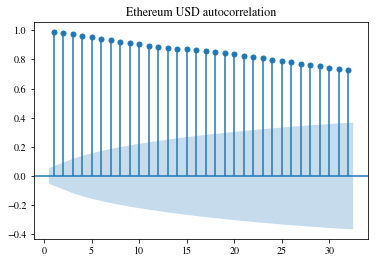

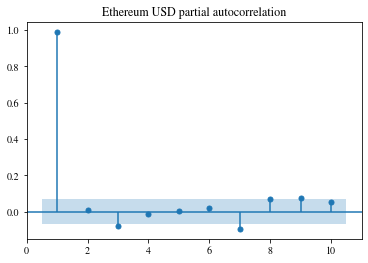

In [24]:
#Autocorrelation functions
series = security.loc[date_range[0]:date_range[1],'Close']
plot_acf(series, title=f'{ticker_name} autocorrelation', zero=False)
plt.show()

plot_pacf(series, lags=10, alpha=.01, title=f'{ticker_name} partial autocorrelation', zero=False)
plt.show()